Microaligner:
https://github.com/VasylVaskivskyi/microaligner

In [1]:
from microaligner import FeatureRegistrator, transform_img_with_tmat
from glob import glob
from dask_image.imread import imread
import matplotlib.pyplot as plt

import numpy as np
plt.rcParams['figure.figsize'] = [10, 10]

In [2]:
root = "/lustre/scratch126/cellgen/team283/tl10/EMBL_training/training/registration/in/"

In [3]:
datas = sorted(glob(f'{root}/*.tif'))

In [4]:
moving_cyc_path, ref_cyc_path = datas[:2]
ref_cyc_path, moving_cyc_path

('/lustre/scratch126/cellgen/team283/tl10/EMBL_training/training/registration/in/NT_FLW_KR0116_DAHN58.1d-S63_Nucleus_Anchor_Background_Background_Background_Meas5_A02_F1T1_max.ome_31671_demo_anchor_32477_40268_36712_44382.ome.tif',
 '/lustre/scratch126/cellgen/team283/tl10/EMBL_training/training/registration/in/NT_FLW_KR0116_DAHN58.1d-S63_Nucleus_AP1-Cy5_AP1-Cy3_AP1-AF488_AP1-Atto425_Meas9_A02_F1T1_max.ome_31576_demo_cycle1_32867_38083_37146_42065.ome.tif')

In [5]:
ref_cyc = imread(ref_cyc_path)
moving_cyc = imread(moving_cyc_path)

In [6]:
ref_cyc.shape, moving_cyc.shape

((5, 4114, 4234), (5, 3981, 4278))

In [7]:
ref_DAPI = ref_cyc[0]
ref_anchor = ref_cyc[1]
moving_DAPI = moving_cyc[0]

(-0.5, 4277.5, 3980.5, -0.5)

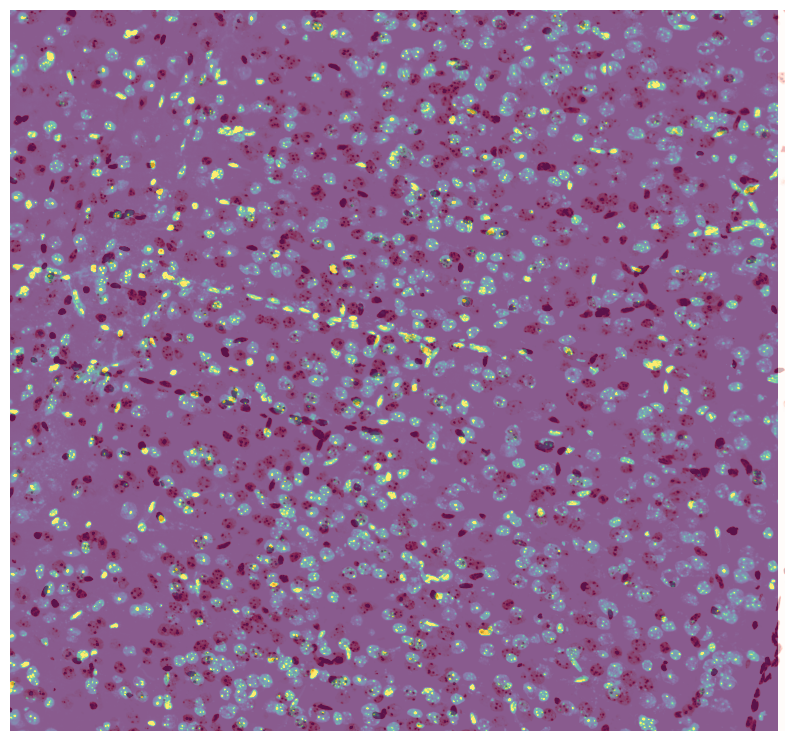

In [8]:
plt.imshow(ref_DAPI, cmap='viridis', alpha=0.9, vmin=180, vmax=2000)
plt.imshow(moving_DAPI, cmap='Reds', alpha=0.3, vmin=180, vmax=2000)
plt.axis('off')

In [16]:
ref_DAPI = ref_DAPI[:moving_DAPI.shape[0], :ref_DAPI.shape[1]]
moving_DAPI = moving_DAPI[:moving_DAPI.shape[0], :ref_DAPI.shape[1]]

In [17]:
ref_DAPI.shape, moving_DAPI.shape

((3981, 4234), (3981, 4234))

(-0.5, 4233.5, 3980.5, -0.5)

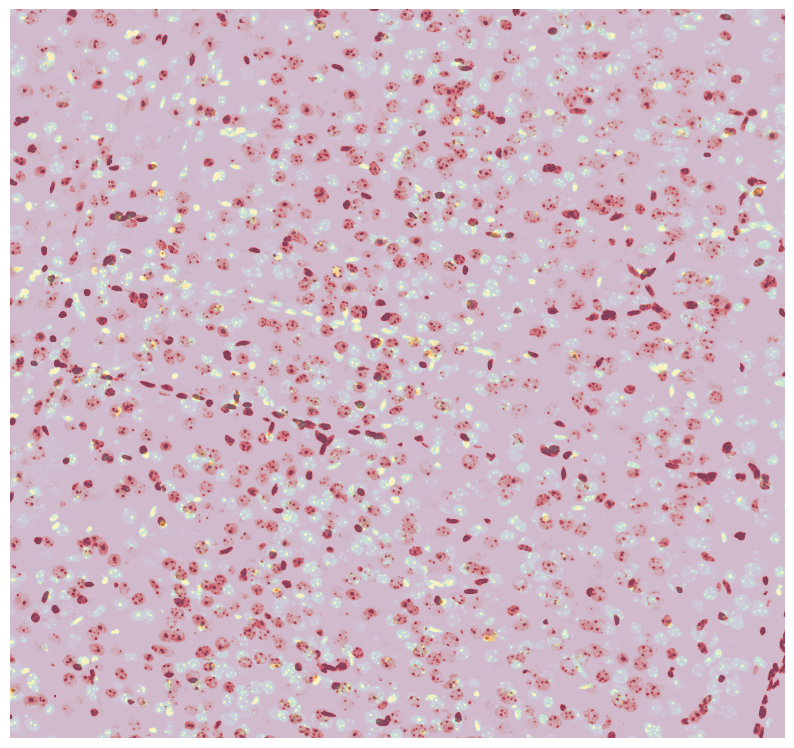

In [18]:
plt.imshow(ref_DAPI, cmap='viridis', alpha=0.5, vmin=180, vmax=2000)
plt.imshow(moving_DAPI, cmap='Reds', alpha=0.5, vmin=180, vmax=2000)
plt.axis('off')

In [22]:
freg = FeatureRegistrator()
freg.ref_img = ref_DAPI.compute()
freg.mov_img = moving_DAPI.compute()
transformation_matrix = freg.register()

img2_feature_reg_aligned = transform_img_with_tmat(moving_cyc[0].compute(), moving_cyc[0].shape, transformation_matrix)

Pyramid factor 8
    Iteration 1 / 3
    Good matches 587 / 3608
    MI score after: 0.312962852235017 | MI score before: 0.01530921428476728
    Better alignment than before
    Iteration 2 / 3
    Good matches 809 / 2914
    MI score after: 0.31686801150195837 | MI score before: 0.312962852235017
    Better alignment than before
    Iteration 3 / 3
    Good matches 809 / 2917
    MI score after: 0.31533173154967215 | MI score before: 0.3174462841556298
    Worse alignment than before
Pyramid factor 4
    Iteration 1 / 3
    Good matches 1165 / 5422
    MI score after: 0.34617379224511613 | MI score before: 0.35011188697882534
    Worse alignment than before
    Iteration 2 / 3
    Good matches 1165 / 5422
    MI score after: 0.35149897312329687 | MI score before: 0.35011188697882534
    Better alignment than before
    Iteration 3 / 3
    Good matches 1223 / 5403
    MI score after: 0.3499012930996388 | MI score before: 0.35149897312329687
    Worse alignment than before
Pyramid fact

In [23]:
another_feature_reg_aligned = transform_img_with_tmat(moving_cyc[1].compute(), moving_cyc[0].shape, transformation_matrix)

(-0.5, 4277.5, 3980.5, -0.5)

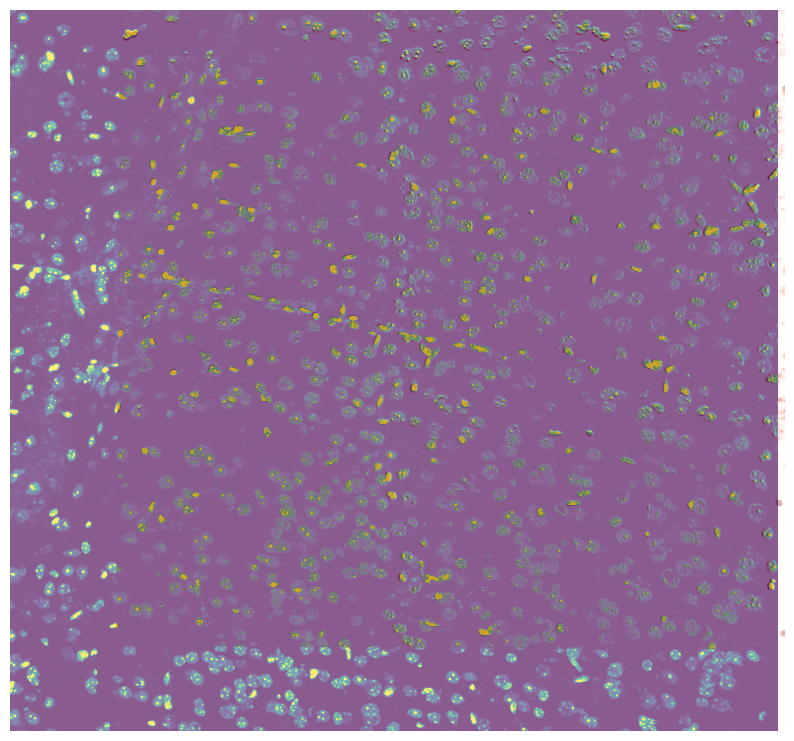

In [24]:
plt.imshow(ref_DAPI, cmap='viridis', alpha=0.9, vmin=180, vmax=2000)
plt.imshow(img2_feature_reg_aligned, cmap='Reds', alpha=0.3, vmin=180, vmax=2000)
plt.axis('off')

In [25]:
ref_DAPI.shape, img2_feature_reg_aligned.shape

((3981, 4234), (3981, 4278))

# Optical flow registration

In [26]:
img2_feature_reg_aligned = img2_feature_reg_aligned[:ref_DAPI.shape[0], :ref_DAPI.shape[1]]
another_feature_reg_aligned = another_feature_reg_aligned[:ref_DAPI.shape[0], :ref_DAPI.shape[1]]

In [28]:
from microaligner import OptFlowRegistrator, Warper 
ofreg = OptFlowRegistrator()
ofreg.ref_img = ref_DAPI.compute()
ofreg.mov_img = img2_feature_reg_aligned
flow_map = ofreg.register()

warper = Warper()
warper.image = img2_feature_reg_aligned
warper.flow = flow_map
img2_optflow_reg_aligned = warper.warp()

Pyramid factor 16
    MI score after: 0.24985224359619032 | MI score before: 0.24721846483916096
    Better alignment than before
Pyramid factor 8
    MI score after: 0.3394296341240388 | MI score before: 0.3185413794094546
    Better alignment than before
Pyramid factor 4
    MI score after: 0.4071439952944337 | MI score before: 0.3510203161554987
    Better alignment than before
Pyramid factor 2
    MI score after: 0.3511959786932326 | MI score before: 0.28687856292897
    Better alignment than before


In [29]:
flow_map

array([[[-0.05357239, -2.7968225 ],
        [-0.05346747, -2.7970848 ],
        [-0.05316589, -2.7978387 ],
        ...,
        [ 0.97698265, -2.605234  ],
        [ 0.97714645, -2.6052246 ],
        [ 0.977201  , -2.6052217 ]],

       [[-0.05367177, -2.7966785 ],
        [-0.05356684, -2.7969408 ],
        [-0.05326525, -2.7976947 ],
        ...,
        [ 0.9770455 , -2.6050136 ],
        [ 0.9772092 , -2.6050043 ],
        [ 0.9772638 , -2.6050012 ]],

       [[-0.0539574 , -2.7962635 ],
        [-0.05385246, -2.7965257 ],
        [-0.05355084, -2.7972791 ],
        ...,
        [ 0.97722614, -2.6043787 ],
        [ 0.9773899 , -2.6043694 ],
        [ 0.9774444 , -2.604366  ]],

       ...,

       [[ 1.44515   ,  0.8682564 ],
        [ 1.4450035 ,  0.86826444],
        [ 1.4445823 ,  0.86828756],
        ...,
        [-0.3952313 ,  0.5005062 ],
        [-0.39505684,  0.5004591 ],
        [-0.39499867,  0.50044334]],

       [[ 1.4451932 ,  0.86839384],
        [ 1.4450467 ,  0.86

(-0.5, 4233.5, 3980.5, -0.5)

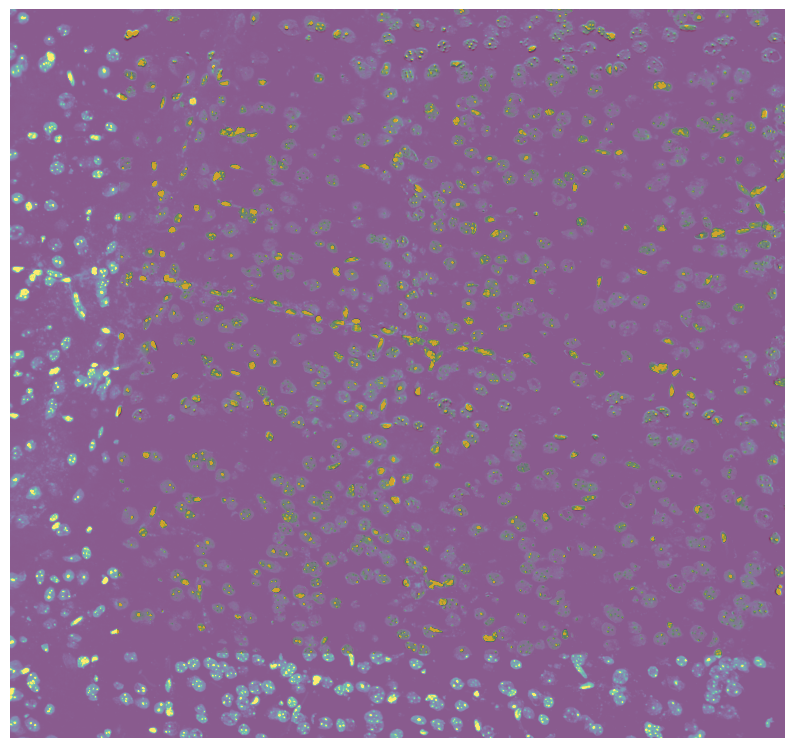

In [30]:
plt.imshow(ref_DAPI, cmap='viridis', alpha=0.9, vmin=180, vmax=2000)
plt.imshow(img2_optflow_reg_aligned, cmap='Reds', alpha=0.3, vmin=180, vmax=2000)
plt.axis('off')

# Wrap another channel

In [31]:
warper = Warper()
warper.image = another_feature_reg_aligned
warper.flow = flow_map
another_optflow_reg_aligned = warper.warp()

(-0.5, 4233.5, 3980.5, -0.5)

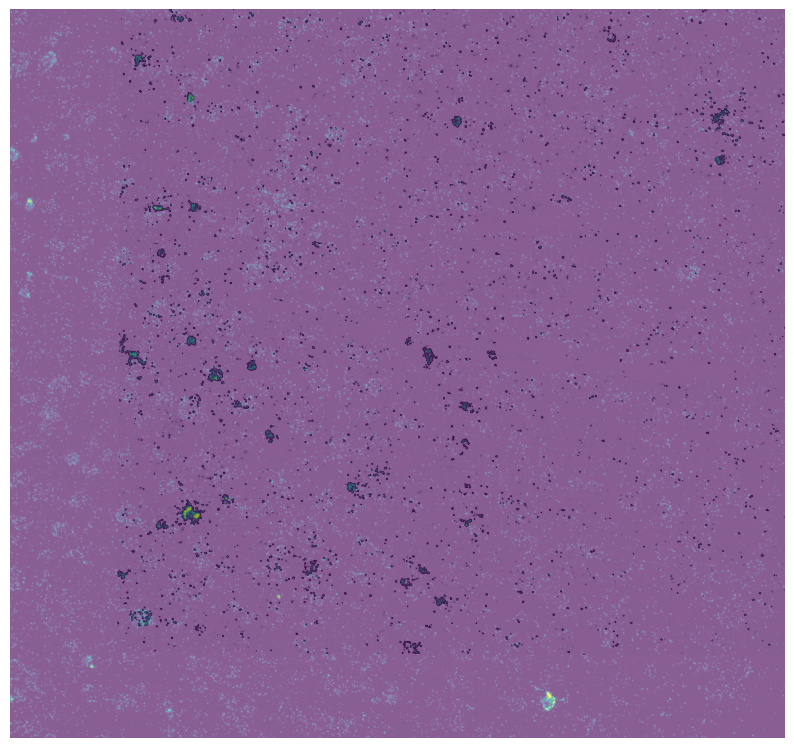

In [37]:
plt.imshow(ref_anchor, cmap='viridis', alpha=0.9, vmin=180)
plt.imshow(another_optflow_reg_aligned, cmap='Greys', alpha=0.3, vmin=180, vmax=2000)
plt.axis('off')